In [186]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as const

Radial advection-diffusion equation according to Charnoz et al. 2011 Eq. (28)

$$\frac{dC}{dt} = \frac{1}{\rho_g r} \frac{\partial}{\partial r} ( -r V_r \rho_g C + r \rho_g D_d \frac{\partial C}{\partial r} )$$

with the dust concentration 

$C = \frac{\rho_d}{\rho_g}$.

$V_r$ is the gas radial velocity which is taken to be zero.

Then the equation to solves becomes the diffusion equation
$$\frac{dC}{dt} = \frac{1}{\rho_g r} \frac{\partial}{\partial r} (r \rho_g D_d \frac{\partial C}{\partial r})$$

In [187]:
#!pip install py-pde h5py pandas pyfftw tqdm
from pde import PDE, CartesianGrid, MemoryStorage, ScalarField, plot_kymograph


In [188]:
Ms = 0.5*u.solMass

r0 = 1*u.au
alpha = 1e-2
h0 = 0.040613
flaring = 0.25
beta = -1

H0 = h0*r0

sigmag0 = 20*u.g/u.cm**2
rhog0 = sigmag0 / (np.sqrt(2*np.pi)*H0)

particle_density = 2.65*u.g/u.cm**3
particle_size = 1e-5*u.cm

vK0 = np.sqrt(const.G*Ms/r0)
OmegaK0 = vK0/r0
cs0 = h0*vK0

ts0 = particle_density*particle_size/(rhog0*cs0)
St0 = ts0 * OmegaK0
St0 = St0.decompose().value

Dg0 = alpha*cs0*h0*r0
Dg0 = Dg0.to_value("au2/yr")

# Youdin & Lithwick 2007 Eq. 37
# Sc = (1 + St**2)**2  / (1 + 4*St**2)

rhog0 = rhog0.to_value('solMass/au3')  
rhog = f"{rhog0} * x**{beta-flaring-1}"

St = f"{St0} * x**(-{beta} - {flaring})"
Sc = f"(1 + ({St})**2)**2 / (1 + 4*({St})**2)"
Dd = f"{Dg0} * x**(0.5+{flaring}) / ({Sc})"
Dd = f"{Dg0} * x**(0.5+{flaring} + 1)"

rhs = f"( d_dx({rhog} * x * {Dd} * d_dx(c) ) ) / ({rhog} * x)"

In [189]:
2**12

4096

In [190]:
simplify(rhs)

45225.158324224751*x**1.25*d_dx(1.6203420943223251e-9*x**0.5*d_dx(c))

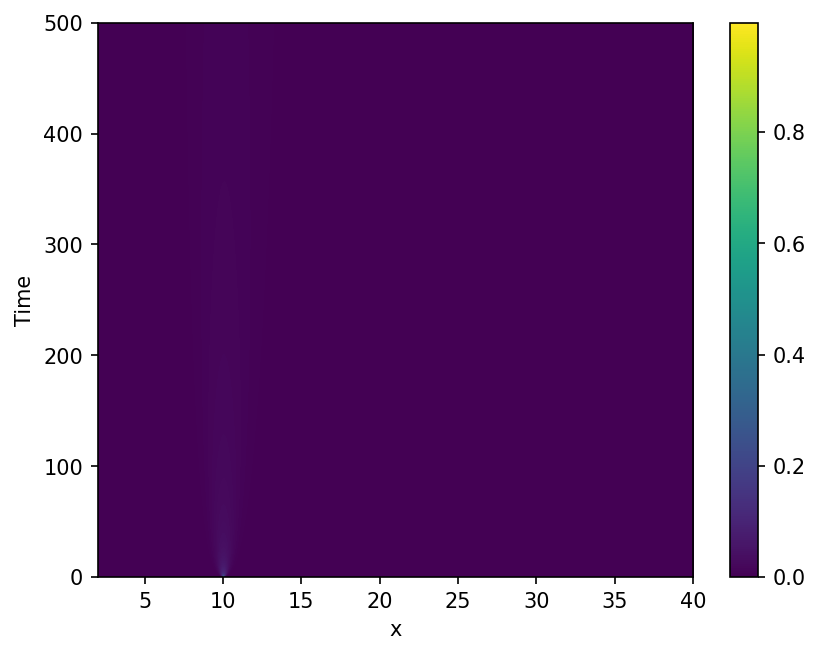

In [197]:

eq = PDE({"c": rhs}, bc={"value": 0})

grid = CartesianGrid([[2, 40]], 2**12 )  # generate grid
coords = grid.cell_coords[:,0]
dinit = np.exp(- 0.5*(grid.cell_coords[:,0]-10)**2/(0.02**2))


field = ScalarField(grid, dinit)  # generate initial condition

storage = MemoryStorage()  # store intermediate information of the simulation
res = eq.solve(field, 500, method='auto', tracker=storage.tracker(1))  # solve the PDE

fig, ax = plt.subplots(dpi=150)

plot_kymograph(storage, ax=ax)  # visualize the result in a space-time plot

(7.0, 13.0)

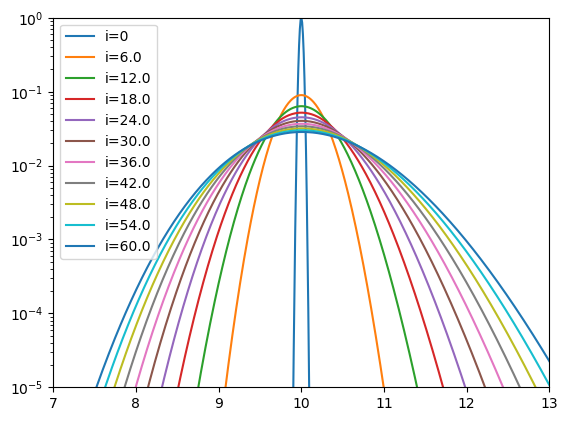

In [196]:
fig, ax = plt.subplots()
N = len(storage)
for i, f in storage.items():
    if not i%(N//10) == 0:
        continue
    d = f.data
    ax.plot(coords, d, label=f"i={i}")

ax.set_yscale("log")
ax.set_ylim(bottom=1e-5, top=1)
ax.legend()
ax.set_xlim(7,13)